This notebook is to determine the required laser power to illuminate the flat field screen.
This uses a single laser that is positioned on the dome. The light then goes into 5 meters of fiber to the center of the screen. Light is sent off a central reflector and down to the telescope.

Currently in Python3 

In [2]:
import numpy as np
import math

import matplotlib.pyplot as plt
import scipy.interpolate

In [3]:
# declare constants
h = 6.626e-34 # m2 kg / s
c = 3e8 # m/s

In [4]:
# Load EKSPLA NT 242-SHG laser output profile
# no actual profile, just guessing from the curve in the PDF file 
#nt242_wave =      np.array([300,320,350,399,400,420,480,500,540,610,700,800,950,1000,1200,1300.0]) # nm
#nt242_energy_J =  np.array([ 20, 45, 30, 10, 45,470,460,460,300,180, 60,130,155, 160, 150,140])*1e-6 # in joules

nt242_data = np.genfromtxt('/Users/patrickingraham/LSST/laser_throughput_calc/Laser_power_data/PGD151_NT242.txt',
                          delimiter='',comments='#') # wavelength [nm], Transmission

nt242_wave = nt242_data[21::,0]
nt242_energy_J = nt242_data[21::,1]*1e-6

#print nt242_wave
#print nt242_energy_J

nt242_pulse_rate_Hz = 1000.0 # 1000 pulses per second

nt242_flux_W = nt242_energy_J * nt242_pulse_rate_Hz # watts

In [5]:
# Load EKSPLA NT 230-SHG laser output profile
# no actual profile, just guessing from the curve in the PDF file 

#nt230_sfg_data = np.genfromtxt('/Users/patrickingraham/LSST/laser_throughput_calc/Laser_power_data/nt230_sfg.csv',
#                          delimiter=',',comments='#') # wavelength [nm], Transmission
#nt230_signal_data = np.genfromtxt('/Users/patrickingraham/LSST/laser_throughput_calc/Laser_power_data/nt230_signal.csv',
#                          delimiter=',',comments='#') # wavelength [nm], Transmission
#nt230_idler_data = np.genfromtxt('/Users/patrickingraham/LSST/laser_throughput_calc/Laser_power_data/nt230_idler.csv',
#                          delimiter=',',comments='#') # wavelength [nm], Transmission

nt230_data_405nm = np.genfromtxt('/Users/patrickingraham/LSST/laser_throughput_calc/Laser_power_data/PGD149_NT230_210nm_405nm.txt',
                          delimiter='',comments='#') # wavelength [nm], Transmission
nt230_data_709nm = np.genfromtxt('/Users/patrickingraham/LSST/laser_throughput_calc/Laser_power_data/PGD149_NT230_405nm_709nm.txt',
                          delimiter='',comments='#') # wavelength [nm], Transmission
nt230_data_2600nm = np.genfromtxt('/Users/patrickingraham/LSST/laser_throughput_calc/Laser_power_data/PGD149_NT230_710nm_2600nm.txt',
                          delimiter='',comments='#') # wavelength [nm], Transmission

nt230_wave0 =      np.concatenate((nt230_data_405nm[:,0],nt230_data_709nm[:,0],nt230_data_2600nm[:,0])) # nm
nt230_energy_J0 =  np.concatenate((nt230_data_405nm[:,1],nt230_data_709nm[:,1],nt230_data_2600nm[:,1]))*1e-3 # in joules
    
nt230_wave=nt230_wave0[20:95]    
nt230_energy_J = nt230_energy_J0[20:95]
    
nt230_pulse_rate_Hz = 100.0 # 100 pulses per second

nt230_flux_W = nt230_energy_J * nt230_pulse_rate_Hz # watts

### Load laser output profile

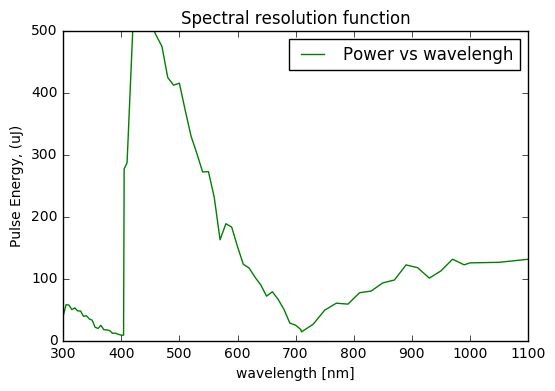

7.799e+16 photons at 325 nm


In [7]:
laser = 'nt242'
if laser == 'nt242':
    laser_flux_W = nt242_flux_W
    laser_wave = nt242_wave
    laser_energy_J = nt242_energy_J
if laser == 'nt230':
    laser_flux_W = nt230_flux_W
    laser_wave = nt230_wave
    laser_energy_J = nt230_energy_J

if 1 == 1:
    if laser == 'nt242':
        conv_fact=1e6
        plt.ylim([0,500])
        plt.xlim([300,1100])
        plt.ylabel('Pulse Energy, (uJ)')
    if laser == 'nt230':
        conv_fact=1e3
        plt.ylim([0,11])
        plt.ylabel('Pulse Energy, (mJ)')
    plt.plot(laser_wave,laser_energy_J*conv_fact,'-g',label="Power vs wavelengh")
    plt.title('Spectral resolution function')
    
    plt.xlabel('wavelength [nm]')
    plt.legend()
    plt.show()
    plt.close()
    
# assume 100 percent effiency and convert to photons
ind=5 # indice of interest
number_of_photons = laser_flux_W / (h*c/(laser_wave*1e-9))  # photons per second
print("%.4g photons at %d nm" % (number_of_photons[ind], laser_wave[ind]) )

### Load beam transfer bench profile

### Bench is Laser -> quarter wave plate -> fiber


In [6]:
quarter_waveplate_throughput = 0.8 # assumption

laser_flux_incident_on_fiber = laser_flux_W * quarter_waveplate_throughput # watts

In [7]:
fiber_splitting_loss = 0.3
print("Assuming %0.4g loss on fiber illumination" % fiber_splitting_loss )
Flux_into_fiber = laser_flux_incident_on_fiber*(1-fiber_splitting_loss) # watts
print(Flux_into_fiber[ind])

Assuming 0.3 loss on fiber illumination
0.026712


In [24]:
# Fiber efficiency - assuming 5 meters length
# plots are in weird units (dB/km) - want to put that into transmission per meter.
# data from http://www.ceramoptec.de/products/fibers/optran-uv-wf.html

fiber_distance = 5 # meters
fiber_wave= np.array([300,350,400,500,600,700,800,900,950,1000,1100.0,1200.0]) # in nm
fiber_att_db_km0 = np.array([140, 70, 35, 15,8.5,  6,  5,  5,6.5, 3.5,   3,2]) # in db/km
# interpolate to have the same wavelengths as nt_242
fiber_att_db_km = scipy.interpolate.griddata(fiber_wave, fiber_att_db_km0, laser_wave, method='linear')
# convert to transmission over the distance
fiber_att = (10**(-fiber_att_db_km/1000*fiber_distance/10.0)) # transmission per m
fiber_att_80 = (10**(-fiber_att_db_km/1000*80.0/10.0)) # transmission per m
#print(laser_wave)
#print(fiber_att)
if 0 == 1:
    plt.plot(laser_wave,fiber_att,'-g')
    plt.plot(laser_wave,fiber_att_80,'-r')
    #plt.plot(fiber_wave, fiber_att_db_km0,'-b')
    plt.title( 'Fiber Transmission over %d meters' % fiber_distance)
    plt.ylabel('Fiber Transmission over %d meters' % fiber_distance)
    plt.xlabel('wavelength [nm]')
    plt.xlim([300,1200])
    plt.legend()
    plt.ylim([0,1])
    plt.show()
    plt.close()

Flux_out_of_fiber = Flux_into_fiber * fiber_att # watts

print("fiber attenuation is %0.3f at %d nm" % (fiber_att[ind],laser_wave[ind]) )

fiber attenuation is 0.886 at 325 nm


### Multiply by end throughput calculation from Ming/Zemax (660nm)

In [25]:
# ming says 0.02% - but that's probably optimistic - assuming 0.01%
FF_system_efficiency =  0.01/100.  # screen photons to detector - 3 Al mirrors - no silver
flux_hitting_focal_plane = Flux_out_of_fiber * FF_system_efficiency # watts

print(flux_hitting_focal_plane[ind])   # watts

2.36704440944e-06


### Remove filter dependence in FRED analysis|

In [26]:
# must divide by filter response at 660nm first - then multiply by the desired filters
r_filter_trans0 = np.genfromtxt('/Users/patrickingraham/LSST/laser_throughput_calc/throughputs/baseline/filter_r.dat',
                          delimiter=' ',comments='#') # wavelength [nm], Transmission
r_filter_trans_660nm = scipy.interpolate.griddata(r_filter_trans0[:,0],r_filter_trans0[:,1], 660, method='linear')

filterless_flux_hitting_focal_plane = flux_hitting_focal_plane / r_filter_trans_660nm



### Convert from energy to photons - get photons per pixel

In [27]:
filterless_flux_hitting_focal_plane_photons = filterless_flux_hitting_focal_plane / (h*c/(laser_wave*1e-9)) # photons per second
#want the number of photons per second hitting eachpixel.
#Flux_hitting_focal_plane_photons[ind]

In [28]:
total_number_of_pixels = 3.2e9 # 3.2 gigapixels
# full_well = 130000 # electrons   - this is actually from DECam but we don't use it here

filterless_flux_per_pixel_per_second = filterless_flux_hitting_focal_plane_photons / total_number_of_pixels
print("Filterless photons per pixel per second is %d at %d nm" % (filterless_flux_per_pixel_per_second[ind],laser_wave[ind]) )

Filterless photons per pixel per second is 1229 at 325 nm


In [29]:
if 0 == 1:
    plt.plot(laser_wave,filterless_flux_per_pixel_per_second,'-g')
    plt.title( 'Filterless Single Laser Incident flux on individual detector pixels',fontsize=20)
    plt.ylabel('Filterless Flux [ph/pix/s]',fontsize=20)
    plt.xlabel('wavelength [nm]',fontsize=20)
    plt.xlim([300,1300])
    plt.text(600, 3200, '**Assumes NO FILTER**')
    plt.legend()
    #plt.ylim([0,1])
    plt.show()
    plt.close()

### Calculate time to complete a monochromatic flat

In [37]:
# assume a required MEDIAN SNR for a given wavelength
med_SNR=100.0

# load a filter (use total transmission since that is what actually
# matters and the filters have leaks that confuse the algorithm)
filter = 'y'  # ugrizy
filename='/Users/patrickingraham/LSST/laser_throughput_calc/throughputs/baseline/total_'+filter+'.dat'
total_trans000 = np.genfromtxt(filename, delimiter=' ',comments='#') # wavelength [nm], Transmission
#find nans and remove them
good = ~np.isnan(total_trans000[:,1])
total_trans0=np.transpose(np.array([total_trans000[good,0], total_trans000[good,1]]))


In [38]:

#print filter_trans0[0:100,:]
#find the X% transmission line 
min_trans=0.01
# first find the wavelength of median bandpass transmission
#cen_ind, = np.where(total_trans0[:,1] == (np.median(total_trans0[:,1] > 0.5)))
cen_ind, = np.where(total_trans0[:,1] > 0.3)
median_trans_value=sorted(total_trans0[cen_ind,1])[int(round(cen_ind.size / 2))]
#print median_trans_value
median_value_ind,=np.where(total_trans0[:,1] == median_trans_value)
#print median_value_ind
#print total_trans0[median_value_ind,0]

# smooth by a few nm to help find the desired transmission boundary % level
tmp= np.convolve(total_trans0[:,1], [0,1,1,1,0], mode='same')

if 0==1:
    plt.plot(total_trans0[:,0],total_trans0[:,1],'-r')
    plt.show()
    plt.close()
    
blue_side_trans_ind2,=np.where( (abs(tmp[0:median_value_ind]-min_trans)) == 
                               (np.nanmin(abs(tmp[0:median_value_ind]-min_trans))) )
red_side_trans_ind2,=np.where( (abs(tmp[median_value_ind::]-min_trans)) == 
                              (np.nanmin(abs(tmp[median_value_ind::]-min_trans))) )

print('blue side minimum total transmission (%0.2f) scan wavelength is %d nm' % (min_trans,total_trans0[blue_side_trans_ind2,0]) )
print('red side minimum total transmission (%0.2f) scan wavelength is %d nm' % (min_trans,total_trans0[median_value_ind+red_side_trans_ind2,0]) )


blue side minimum total transmission (0.01) scan wavelength is 880 nm
red side minimum total transmission (0.01) scan wavelength is 1081 nm


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


median count rate for y-band is 2236 photons/sec with the nt242 laser
y-band will take 0.25 hours for an median SNR of 100
y-band will have an integrated SNR of 1531 


//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


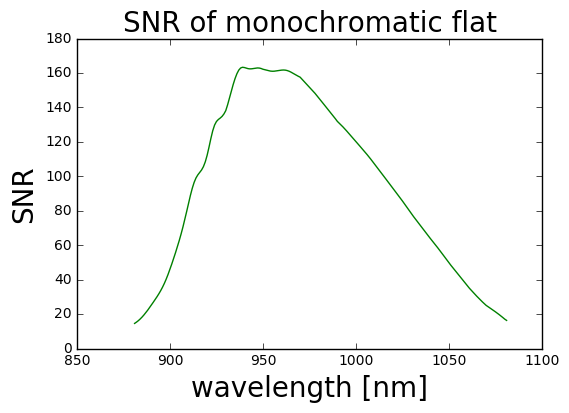

In [39]:

# define filter bandpass range
filter_bandpass = np.arange(total_trans0[blue_side_trans_ind2,0],
                            total_trans0[median_value_ind+red_side_trans_ind2,0])

# load detector efficiency
det_filename='/Users/patrickingraham/LSST/laser_throughput_calc/throughputs/baseline/detector_120227.dat'
detector0 = np.genfromtxt(det_filename, delimiter='',comments='#') # wavelength [nm], Transmission
#interpolate to filter_bandpass
detector_efficiency = scipy.interpolate.griddata(detector0[:,0],detector0[:,1], filter_bandpass, method='linear')

# load the filter curve
filename='/Users/patrickingraham/LSST/laser_throughput_calc/throughputs/baseline/filter_'+filter+'.dat'
filter_trans0 = np.genfromtxt(filename, delimiter=' ',comments='#') # wavelengt
#get filter transmission for this bandpass
filter_transmission = scipy.interpolate.griddata(filter_trans0[:,0],
                                                 filter_trans0[:,1], filter_bandpass, method='linear')

# determine filterless and detectorless count rate average
filterless_count_rate = scipy.interpolate.griddata(laser_wave,filterless_flux_per_pixel_per_second,
                                                   filter_bandpass, method='linear') 
count_rate = filterless_count_rate * filter_transmission * detector_efficiency
    
median_count_rate = np.median(count_rate)
print('median count rate for %s-band is %d photons/sec with the %s laser' % (filter ,median_count_rate,laser) )

# determine how long it will take to collect med_SNR^2 of photons
time = (med_SNR**2) / median_count_rate * filter_bandpass.size / 3600  # in hours
print('%s-band will take %0.2f hours for an median SNR of %d' % (filter,time,med_SNR) )

snr_per_wave=np.sqrt(count_rate* ((med_SNR**2) / median_count_rate))
integrated_snr= np.sqrt(sum(count_rate* ((med_SNR**2) / median_count_rate)))

print('%s-band will have an integrated SNR of %d ' % (filter, integrated_snr) )

# create SNR plot
if 1 == 1:
    plt.plot(filter_bandpass,snr_per_wave,'-g')
    plt.title( 'SNR of monochromatic flat',fontsize=20)
    plt.ylabel('SNR',fontsize=20)
    plt.xlabel('wavelength [nm]',fontsize=20)
    #if ignore_sphere == 1:
    #    plt.text(600, 3000, '**Assuming NO integration sphere**')
    plt.legend()
    #plt.ylim([0,1])
    plt.show()
    plt.close()

In [29]:
# Sphere efficiency - from labsphere theory and app document


# assume labsphere AS-02284-033 , 3.3 inch diameter sphere with spectralon. 2 output ports - each 1.5 inch diameter
rho= 0.985  # spectralon reflectance - actually has a very slight wavelength dependence - will put that in later

sphere_radius = (3.3/2)*0.0254 # in meters
input_port_radius = (1.5/2 ) * 0.0254 # in meters
output_port_radius = (1.5/2 ) * 0.0254 # in meters
A_sphere = 4.0 * np.pi * (sphere_radius**2)# area of the sphere
A_input = np.pi * (input_port_radius**2)# input port area
A_exit = np.pi * (output_port_radius**2)# exit port area
f = (A_input + A_exit)/A_sphere # port fraction = 0.045
# efficiency = 1.33e-5


#assume labsphere AS-02281-010, 1 inch radius sphere with spectralon. 2 output ports - each 1 inch diameter
rho= 0.985  # spectralon reflectance - actually has a very slight wavelength dependence - will put that in later
sphere_radius = (1/2.)*0.0254 # in meters
input_port_radius = (0.25/2 ) * 0.0254 # in meters
output_port_radius = (0.25/2 ) * 0.0254 # in meters
A_sphere = 4.0 * np.pi * (sphere_radius**2)# area of the sphere
A_input = np.pi * (input_port_radius**2)# input port area
A_exit = np.pi * (output_port_radius**2)# exit port area
f = (A_input + A_exit)/A_sphere # port fraction


Ls = ( laser_flux_into_int_sphere / (np.pi * A_sphere) ) * ( rho / (1- rho*(1-f)) ) # eq 12 - Watts/m2

# Fiber bundle coupling efficiency - assuming Optran WF fiber
NA=0.22
fiber_reflectivity = 0.5 # small wavelength dependence ( assumes silica fiber, n=3.5, angle of in = 12 deg (atan(NA))
core_radius = 75e-6 # assuming 75um radius
core_area = np.pi*(core_radius**2) # [m2]
N_fibers = 42.0 #nominally 28, assume 50% spares
Af = core_area*N_fibers

Flux_into_fiber = Ls * Af * np.pi * (NA**2)*(1-fiber_reflectivity)  # [watts]

# plot sphere efficiency
if 1 == 1:
    print("sphere to fiber efficiency %f" % (Flux_into_fiber[5]/laser_flux_into_int_sphere[5]) )
    #print laser_wave[5]
    #plt.plot(laser_wave,Flux_into_fiber/laser_flux_into_int_sphere,'-g')
    #plt.title( 'Sphere efficiency')
    #plt.ylabel('Sphere to Fiber Transmission')
    #plt.xlabel('wavelength [nm]')
    #plt.legend()
    ##plt.ylim([0,1])
    #plt.show()
    #plt.close()

    # bypass sphere
    ignore_sphere = 1
    if ignore_sphere == 1:
        print( "Bypassing Integration sphere")

NameError: name 'laser_flux_into_int_sphere' is not defined

In [14]:
import numpy
import scipy
import scipy.linalg
import matplotlib.pyplot as plt
import matplotlib

In [15]:
print(numpy.__version__)
print(scipy.__version__)
print(matplotlib.__version__)


1.9.2
0.15.1
1.4.3


In [17]:
x = numpy.linspace(0, 20, 100)
plt.plot(x, math.sin(x))
print(scipy.linalg.eig([[1,2],[3,4]]))

TypeError: only length-1 arrays can be converted to Python scalars

In [21]:
print(math.sin(x[:]))

TypeError: only length-1 arrays can be converted to Python scalars